In [5]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bensonmanner/Desktop/ACME/WebbResearch/Projects/Optimization/delay-optimizer')
import os
import json
from Optimizer_Scripts.learning_rate_generator import generate_learning_rates
from Optimizer_Scripts.param_optimizer_helper import test_builder
from Optimizer_Scripts import Delayer
from Optimizer_Scripts import optimizers 
from Optimizer_Scripts import functions
from matplotlib import ticker

# Helper Functions

In [25]:
def run_single_start(delayer, x_init, maxiter=1000, tol=1e-5, use_delays=True, D=None, random=True):
    delayer.x_init = x_init
    delayer.compute_time_series(tol=tol, maxiter=maxiter, use_delays=use_delays, random=random, D=D)
    return delayer


def set_axis_attributes(ax, plot_dims, range_grid):
    for it, (dim_0, dim_1) in enumerate(plot_dims):
        axis = ax[it]
        axis.set_xlabel("Dimension {}".format(dim_0))
        axis.set_ylabel("Dimension {}".format(dim_1))
        axis.set_xlim(range_grid)
        axis.set_ylim(range_grid)
        
    
def plot_values(axis, value, iters, vmax=25.0, vmin=0.0, time_plot=False, cmap='winter', conv_plot=False, grid=None, contour_plot=False):
    #plot the results according to the given delayer
    color = 'r'
    if cmap == 'winter':
        color = 'b'
    if vmin > 0:
        vmin = 0
    if conv_plot is False:
        for i in range(len(value[0])):
            value_2 = value[2][i]
            if (time_plot is True):
                value_2 = np.flip(np.arange(1,len(value_2)+1,1))
                vmin = 0
                vmax = len(value_2)
                axis.plot(value[0][i], value[1][i], color=color, alpha=0.3)

            value_0 = value[0][i]
            value_1 = value[1][i]
            im = axis.scatter(value_0, value_1,c=value_2, vmin=vmin, vmax=vmax, alpha=0.01, cmap=cmap, s=100)
    else:
        X, Y = grid
        Z = np.zeros(len(X)*len(Y))
        for i in range(len(value[0])):
            Z[i] = value[2][i][-1]
            if Z[i] == -1:
                Z[i] = np.nan
                
        Z = np.resize(Z, (len(X),len(Y))).T
        axis.patch.set_color('.25')
        im = axis.contourf(X, Y, Z, cmap=cmap)
        
        if contour_plot is True:
            f = lambda x,y: (x-1)**2 + 100*(y-x**2)**2
            Z = f(X,Y)
            axis.contour(X, Y, f(X, Y), locator=ticker.LogLocator(), cmap='inferno')

    return im
    
    
def add_new_values(value, dim_tuple, delayer, type_plot):
    value[0].append(delayer.time_series[1:,dim_tuple[0]].tolist())
    value[1].append(delayer.time_series[1:,dim_tuple[1]].tolist())
    if (type_plot == 'loss'):
        value[2].append(delayer.loss_list)
    elif (type_plot == 'gradient'):
        value[2].append(delayer.grad_list)
    elif (type_plot == 'iters'):
        if delayer.conv is True:
            value[2].append([len(delayer.loss_list)])
        else:
            value[2].append([-1])
    max_val = max(max(value[2]))
    min_val = min(min(value[2]))
    return value, max_val, min_val 

    
def create_grid(range_grid, num_points, n):
    x = np.linspace(range_grid[0], range_grid[1], num_points)
    #create the mesh
    list_xs = [x for i in range(n)]
    initials = itertools.product(*list_xs)
    X, Y = np.meshgrid(x, x)
    grid = [X, Y]
    return initials, grid


def plot_colorbar(fig, axis, image):
    colorbar = fig.colorbar(image, ax=axis)
    colorbar.set_alpha(1)
    colorbar.draw_all()
    
    
def print_vals(use_delays, min_loss, avg_loss):
    if use_delays:
        print_message = "Delayed Loss"
    else:
        print_message = "Loss"
    print("Minimum ", print_message, ": ", min_loss, sep="")
    print("Average ", print_message, ": ", avg_loss, sep="")
    

def plot_results(plot_dims, values, vmax, vmin, final_losses, final_states, iters, fig, ax, colorbar=True, use_both=False, time_plot=False, conv_plot=False, grid=None, contour_plot=False):
    #now plot on each axis in the list of axes
    alpha_hist = 1.0
    final_del_losses = None
    final_del_states = None
    if (use_both is True):
        values, values_del = values
        vmax, vmax_del = vmax
        vmin, vmin_del = vmin
        final_losses, final_del_losses = final_losses
        final_states, final_del_states = final_states
        iters, del_iters = iters
        final_del_states = np.ravel(np.asarray(final_del_states))
        alpha_hist = 0.3  
    for it in range(len(plot_dims)):
        axis = ax[it]
        bins=25
        
        #plot the other plot if use both is true
        if (use_both is True):
            im1 = plot_values(axis, values_del[it], del_iters, vmax=vmax_del, vmin=vmin_del, cmap='autumn', time_plot=time_plot, conv_plot=conv_plot, grid=grid, contour_plot=contour_plot) 
            bins=25
        im = plot_values(axis, values[it], iters, vmax=vmax, vmin=vmin, time_plot=time_plot, conv_plot=conv_plot, grid=grid, contour_plot=contour_plot)
        if (colorbar is True):
            plot_colorbar(fig, axis, im)
    final_states = np.ravel(np.asarray(final_states))
    ax[-2].hist(final_states, alpha=alpha_hist, color='b',bins=bins)
    ax[-2].set_title("Final State Values")
    ax[-1].hist(final_losses, alpha=alpha_hist, color='b',bins=bins)
    ax[-1].set_title("Final Loss Values")
    #plot the delayed finals if we did both
    if final_del_losses is not None:
        ax[-2].hist(final_del_states, alpha=alpha_hist, color='r',bins=bins)
        ax[-1].hist(final_del_losses, alpha=alpha_hist, color='r',bins=bins)

        
def calculate_save_values(delayer, initials, plot_dims, maxiter, tol, use_delays, gen_params, type_plot,
                         random=True, D=None):
    #plot the results according to the given dimensions
    values = [[[], [], []] for i in range(len(plot_dims))]
    final_losses = list()
    final_states = list()
    iters = list()
    total_min = np.inf
    total_max = -np.inf
    #get the relevant variables from the delayer
    loss, grad, params, n = delayer.loss_function, delayer.grad, delayer.Optimizer.params, delayer.n
    max_L, num_delays = delayer.max_L, delayer.num_delays
    for x_init in initials:
        x_init = np.asarray(x_init)
        delayer = run_single_start(delayer, x_init, maxiter, tol, use_delays, random=random, D=D)
        for it in range(len(values)):
            dim_tuple = plot_dims[it]
            value = values[it]
            values[it], max_val, min_val = add_new_values(value, dim_tuple, delayer, type_plot)
            if (max_val > total_max):
                total_max = max_val
            if (min_val < total_min):
                total_min = min_val
        final_losses.append(delayer.final_val)
        final_states.append(delayer.final_state)
        if delayer.conv is True:
            iters.append(len(delayer.time_series))
        else:
            iters.append(-1)
        #recreate the delayer to reset the learning rate generater
        del delayer
        params['learning_rate'] = generate_learning_rates(False, gen_params)
        optim = optimizers.Adam(params)
        delayer = Delayer.Delayer(n, optim, loss, grad, max_L=max_L, 
                                  num_delays=num_delays, compute_loss=True,
                                  save_grad=True)
    #TODO - create minval 0 option
    return values, final_losses, final_states, iters, max_val, min_val, delayer

        
def initialize_optimizer(optimizer='Adam', loss='Ackley', n=2, max_L=1, num_delays=1000, uncoupled=False):
    #get the loss and gradients
    loss=functions.ackley_gen(n)
    grad=functions.ackley_deriv_gen(n)
    #create the optimizer
    max_L=max_L
    num_delays=num_delays
    params=dict()
    params['beta_1'] = 0.9
    params['beta_2'] = 0.999
    gen_params = {'step_size': 740, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
    params['learning_rate'] = generate_learning_rates(False, gen_params)
    optim = optimizers.Adam(params)
    delayer = Delayer.Delayer(n, optim, loss, grad, max_L=max_L, 
                              num_delays=num_delays, compute_loss=True,
                              save_grad=True)
    return delayer, gen_params
    
    
def optimizer_path_tracker(range_grid=[-32.,32.], num_points=100, maxiter=2000, tol=1e-5,
                use_delays=True, n=1000, plot_dims=[(0,1),(2,3), (92,93), (84,85)], type_test='random', conv_plot=False,
                do_both=False, num_delays=1000, max_L=1, type_plot='loss', colorbar=True, time_plot=False,
                random=True, D=None, uncoupled=False, contour_plot=False):
    #the different types of initial values
    if type_test == 'random':
        initials = np.random.uniform(range_grid[0], range_grid[1], size=(num_points,n))
    elif type_test == 'grid':
        initials, grid = create_grid(range_grid, num_points, n)
    elif type_test == 'same':
        initials = np.random.uniform(range_grid[0], range_grid[1], size=n)
        initials = np.tile(initials, (num_points, 1))
    if conv_plot is False:
        grid = None
    #initalize optimizer and parameters
    delayer, gen_params = initialize_optimizer(n=n, max_L=max_L, num_delays=num_delays, uncoupled=uncoupled)
    #plot the results on a loss/dimension scatter plot
    title = "{}: {} Optimizer: {} Dimensions: {} is max delay".format('Ackley', delayer.Optimizer.name, delayer.n, delayer.max_L)
    fig,ax=plt.subplots(len(plot_dims)+2,1,figsize=(10,8*(len(plot_dims)+2)))
    #now make ax a list if it is not already
    if type(ax) is not np.ndarray:
        ax = np.array([ax])
    #set the labels on the axes
    set_axis_attributes(ax,plot_dims,range_grid)
    #calculate the relavant values
    if (do_both is False):
        values, final_losses, final_states, iters, vmax, vmin, delayer = calculate_save_values(delayer, initials, plot_dims, 
                                                                                        maxiter, tol, use_delays, 
                                                                                        gen_params, type_plot,
                                                                                        random, D)
    else:
        values_del, final_del_losses, final_del_states, del_iters, vmax_del, vmin_del, delayer = calculate_save_values(delayer, initials, 
                                                                                                            plot_dims, maxiter, 
                                                                                                            tol, True, gen_params, 
                                                                                                            type_plot, random, D)
        values, final_losses, final_states, iters, vmax, vmin, delayer = calculate_save_values(delayer, initials, plot_dims, 
                                                                                        maxiter, tol, False, gen_params, 
                                                                                        type_plot, random, D)
        values, final_losses, final_states, iters, vmax, vmin = ((values, values_del), (final_losses, final_del_losses), 
                                                         (final_states, final_del_states), (iters, del_iters), (vmax, vmax_del), 
                                                         (vmin, vmin_del))
        
    del delayer
    
        
    plot_results(plot_dims, values, vmax, vmin, final_losses, final_states, iters, fig, ax, colorbar=colorbar, 
                 use_both=do_both, time_plot=time_plot, conv_plot=conv_plot, grid=grid, contour_plot=contour_plot)
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()
    
    if do_both:
        print_vals(False, np.min(final_losses[0]), np.mean(final_losses[0]))
        print_vals(True, np.min(final_losses[1]), np.mean(final_losses[1]))
    else:
        print_vals(use_delays, np.min(final_losses), np.mean(final_losses))

# Stochastic Delays

## 2d Loss - Undelayed

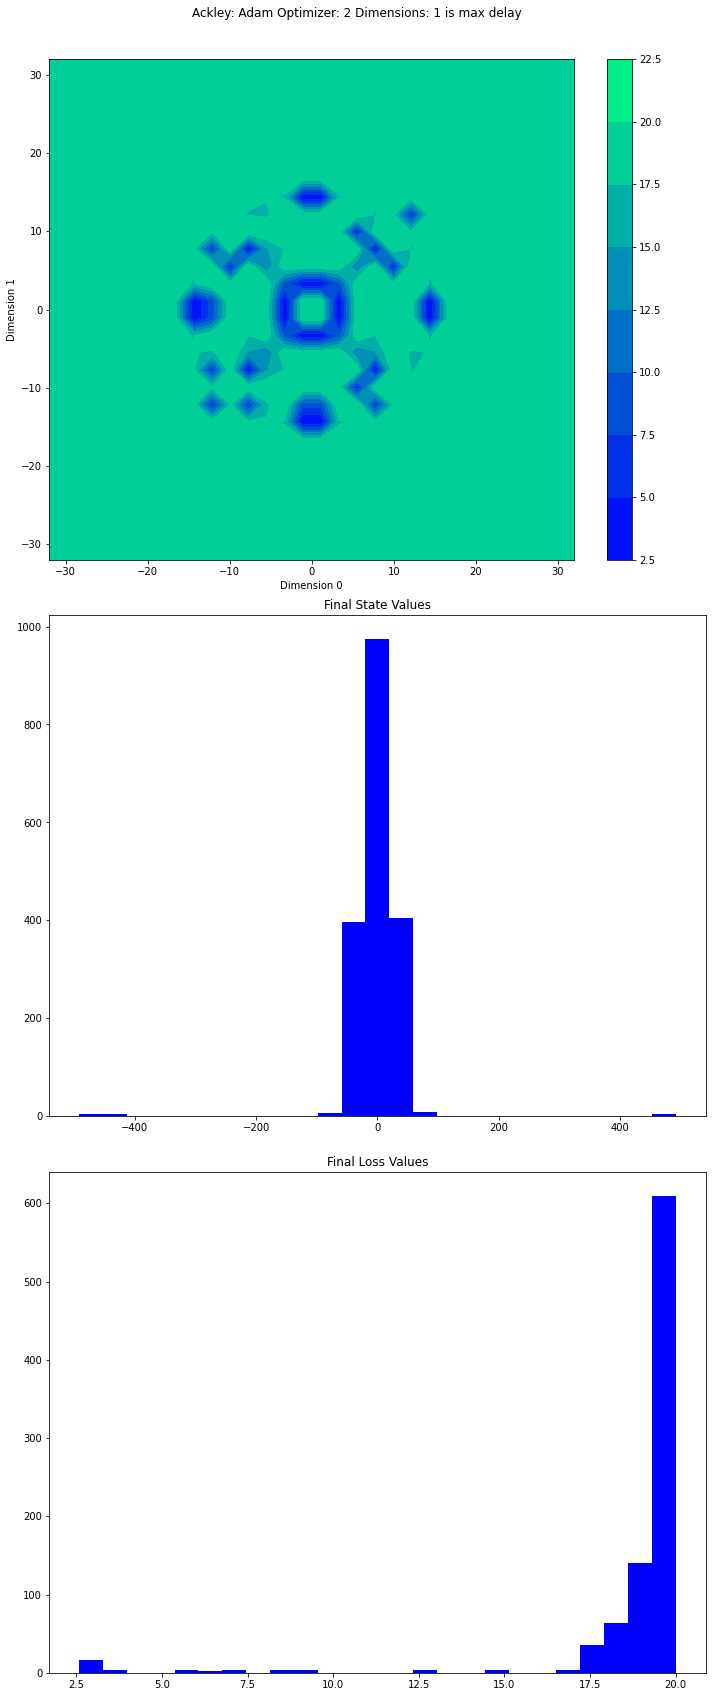

Minimum Loss: 2.5799275647142896
Average Loss: 18.753987924359894


In [26]:
optimizer_path_tracker(range_grid=[-32.,32.], num_points=30, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2, colorbar=True, conv_plot=True, contour_plot=False)

## 2d Loss - Delayed

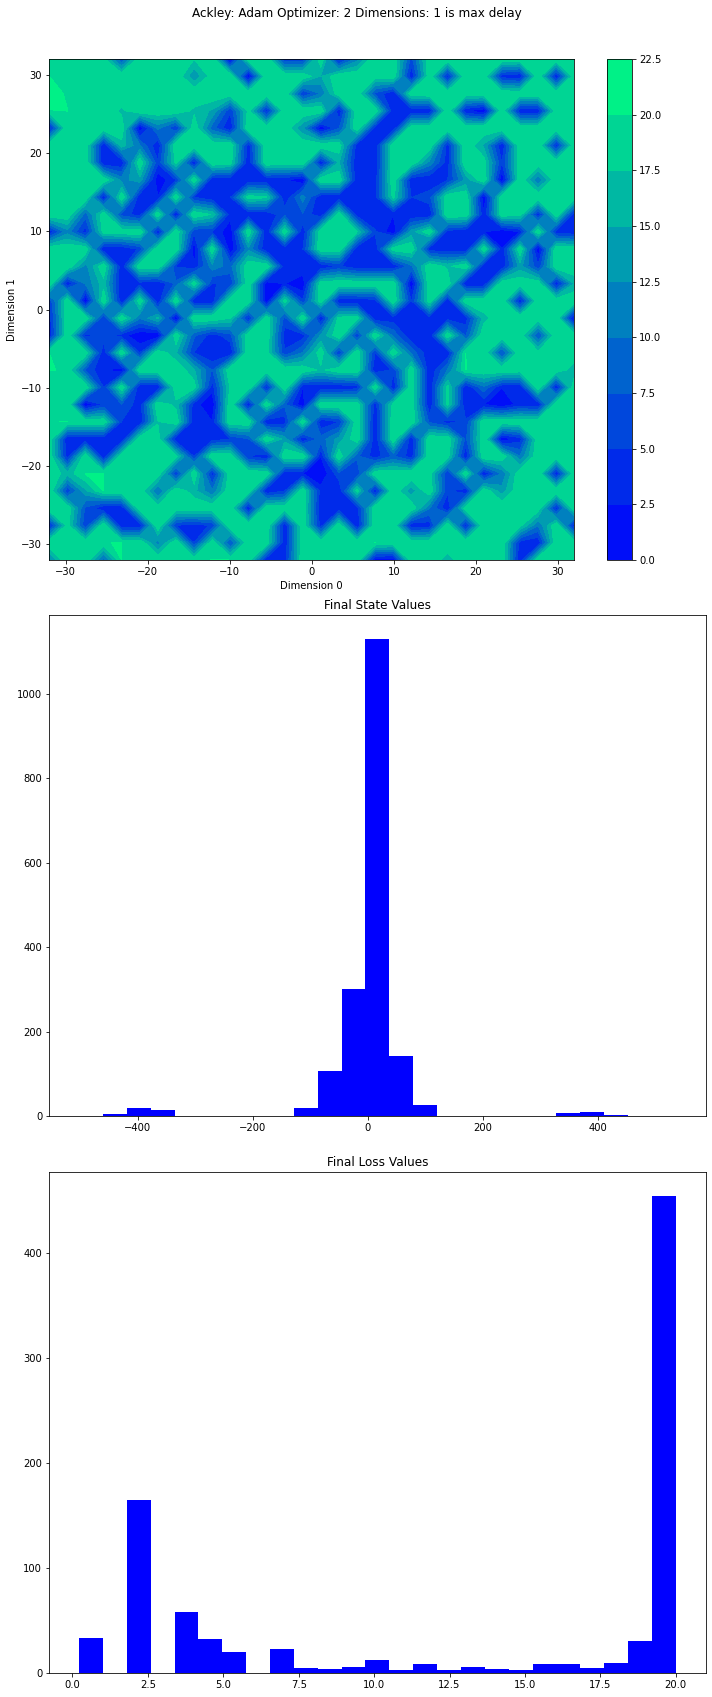

Minimum Delayed Loss: 0.2183716277649883
Average Delayed Loss: 13.111195280673565


In [27]:
optimizer_path_tracker(range_grid=[-32.,32.], num_points=30, use_delays=True, plot_dims=[(0,1)], type_test='grid', n=2, colorbar=True, conv_plot=True, contour_plot=False)

## 2d Iterations - Undelayed

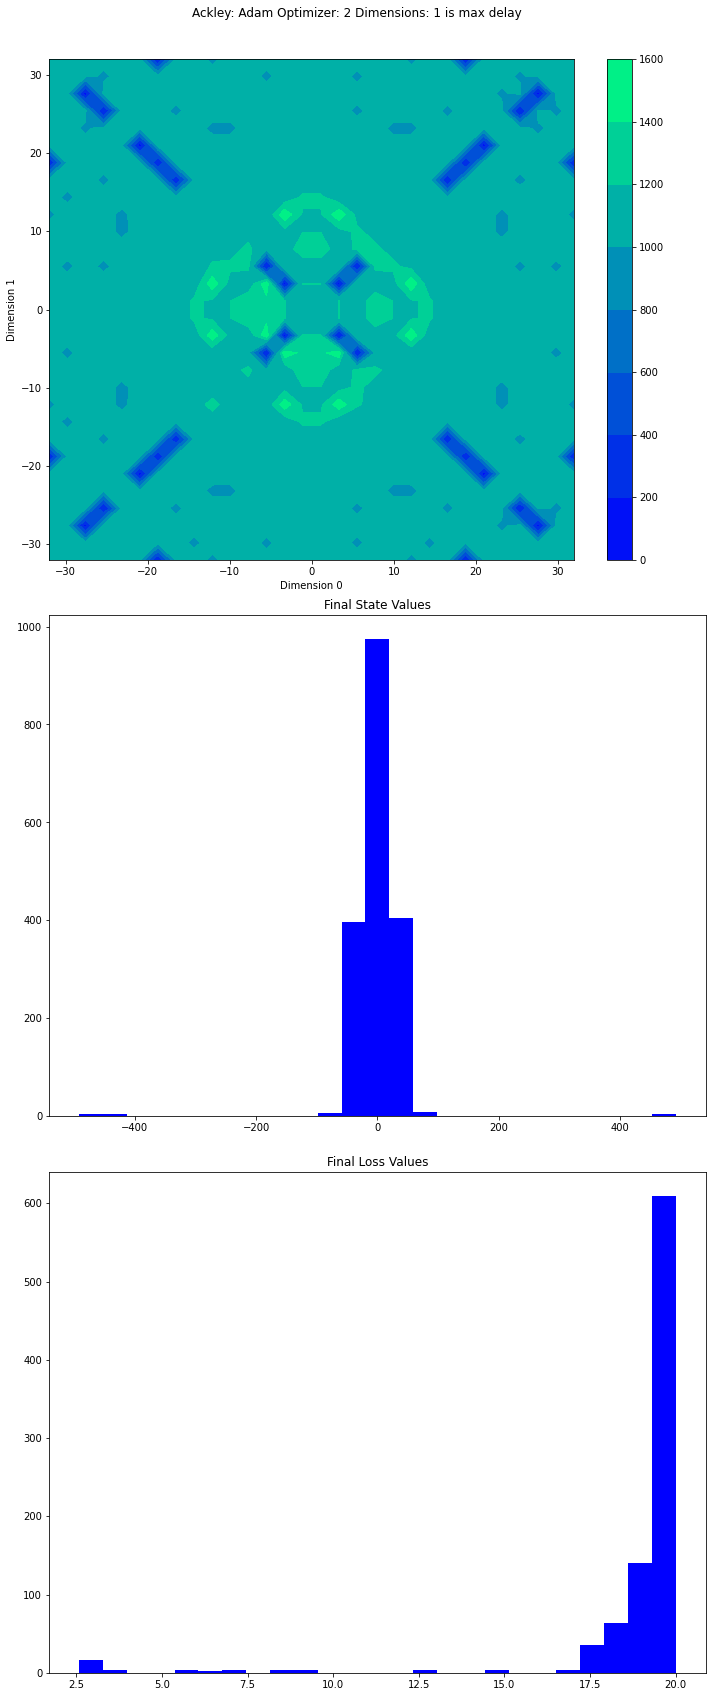

Minimum Loss: 2.5799275647142896
Average Loss: 18.753987924359894


In [28]:
optimizer_path_tracker(range_grid=[-32.,32.], num_points=30, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2, colorbar=True, conv_plot=True, contour_plot=False, type_plot='iters')

## 2d Iterations - Delayed

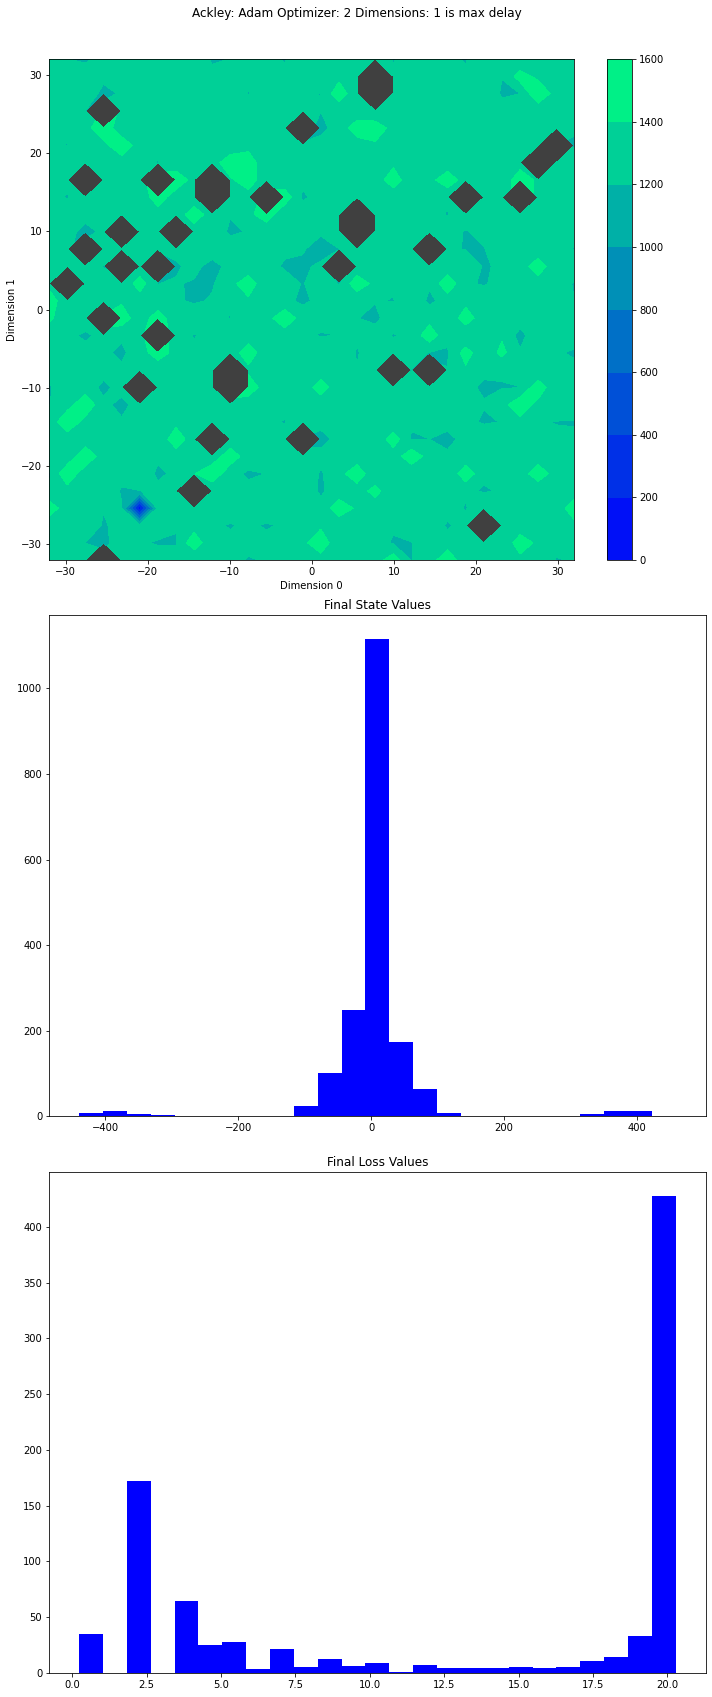

Minimum Delayed Loss: 0.23025116436432969
Average Delayed Loss: 12.79077045989818


In [29]:
optimizer_path_tracker(range_grid=[-32.,32.], num_points=30, use_delays=True, plot_dims=[(0,1)], type_test='grid', n=2, colorbar=True, conv_plot=True, contour_plot=False, type_plot='iters')

## 2d Gradient - Undelayed

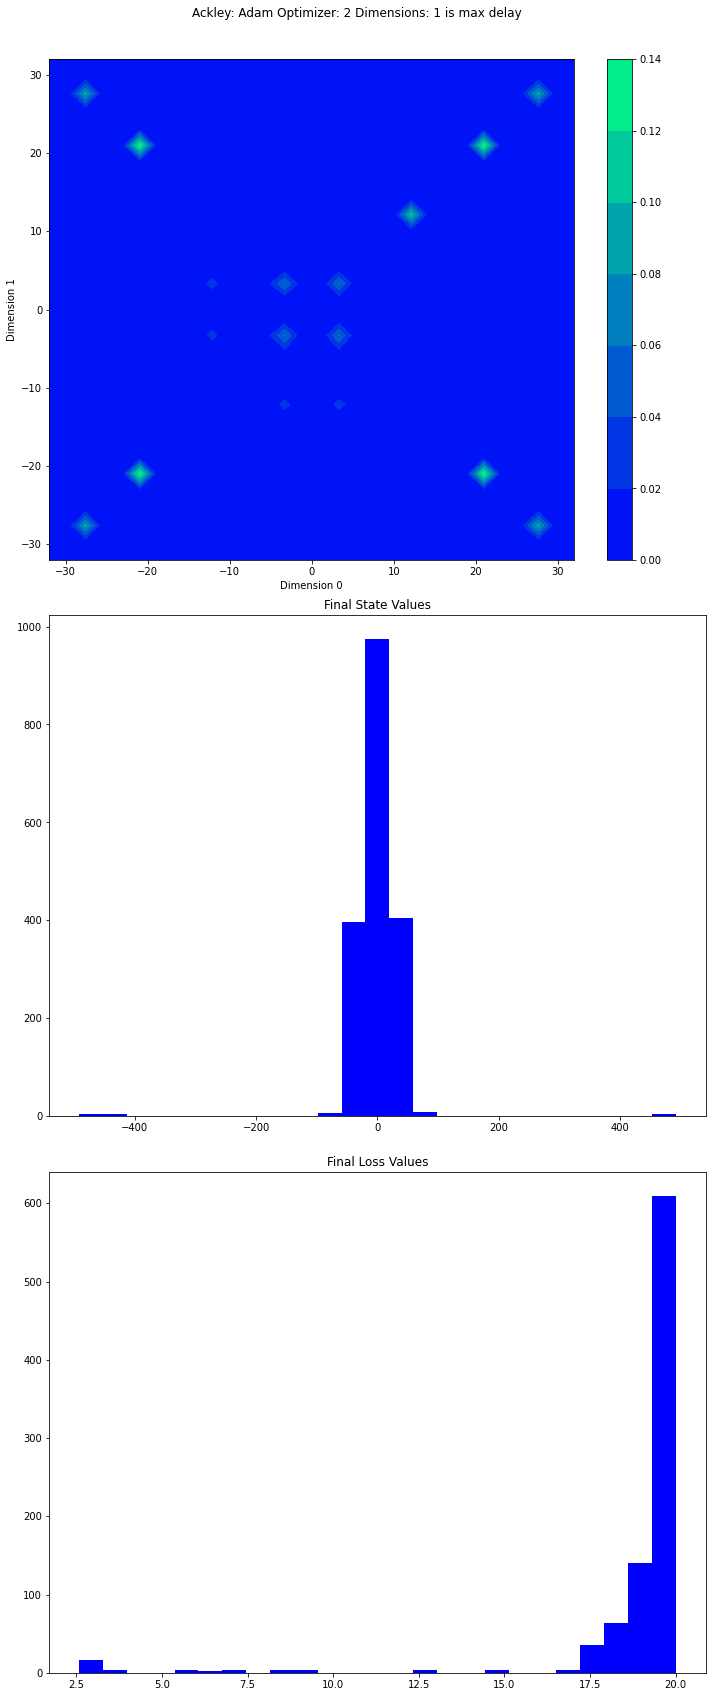

Minimum Loss: 2.5799275647142896
Average Loss: 18.753987924359894


In [30]:
optimizer_path_tracker(range_grid=[-32.,32.], num_points=30, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2, colorbar=True, conv_plot=True, contour_plot=False, type_plot='gradient')

## 2d Gradient - Delayed

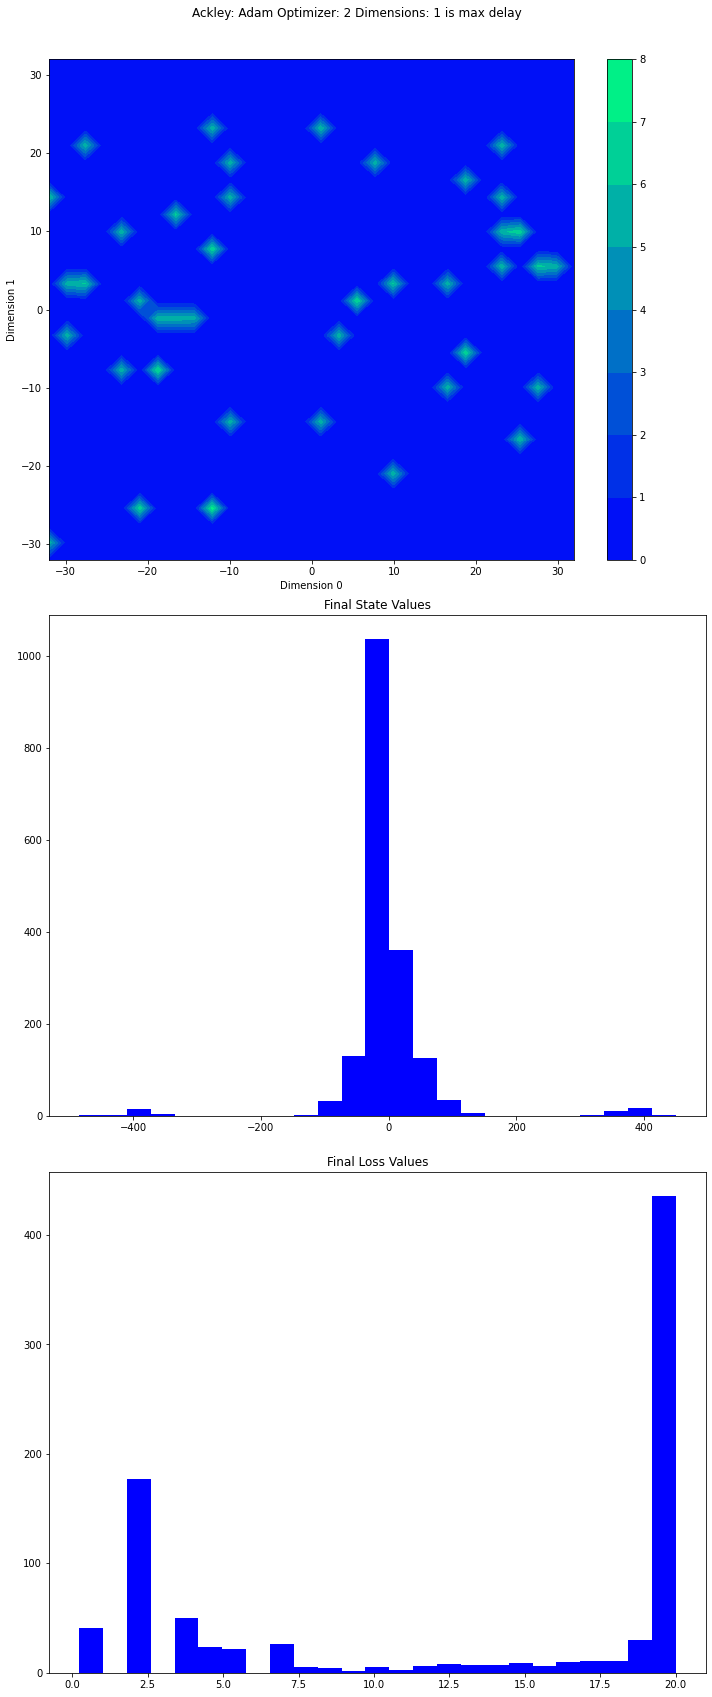

Minimum Delayed Loss: 0.22504320649016352
Average Delayed Loss: 12.934173994243352


In [31]:
optimizer_path_tracker(range_grid=[-32.,32.], num_points=30, use_delays=True, plot_dims=[(0,1)], type_test='grid', n=2, colorbar=True, conv_plot=True, contour_plot=False, type_plot='gradient')

# 2d Constant Time Delays - 1